In [52]:
from __future__ import absolute_import
from __future__ import print_function
import numpy as np
np.random.seed(1337)  # for reproducibility
import random
from keras.datasets import mnist
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Conv2D, Lambda, merge, Dense, Flatten, MaxPooling2D, Dropout
from keras.optimizers import RMSprop
from keras import backend as K
from keras.optimizers import SGD
import matplotlib.pyplot as plt
%matplotlib inline

## Triplet loss model training

In [1]:
def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(10)]) - 1
    for d in range(10):
        for i in range(n):
            inc = random.randrange(1, 10)
            dn = (d + inc) % 10
            z1, z2, z3 = digit_indices[d][i], digit_indices[d][i + 1], digit_indices[dn][i]
            pairs += [[x[z1], x[z2], x[z3]]]
            labels += [[0,0]]
    return np.array(pairs),np.array(labels)

In [38]:
# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train_image = X_train
X_test_image = X_test
X_train = X_train.reshape(60000, 28, 28, 1)
X_test = X_test.reshape(10000, 28, 28, 1)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
input_shape = (28,28,1)
nb_epoch = 3
num_classes = 1
# create training+test positive and negative pairs
digit_indices = [np.where(y_train == i)[0] for i in range(10)]
tr_pairs, tr_y = create_pairs(X_train, digit_indices)

digit_indices = [np.where(y_test == i)[0] for i in range(10)]
te_pairs, te_y = create_pairs(X_test, digit_indices)

In [39]:
tr_pairs.shape

(54200, 3, 28, 28, 1)

In [40]:
tr_y.shape

(54200, 2)

In [41]:
def create_base_network(input_shape):
    model = Sequential()  
    model.add(Conv2D(filters=16,  
                 kernel_size=(5,5),  
                 padding='same',  
                 input_shape=input_shape,  
                 activation='relu'))  
    model.add(MaxPooling2D(pool_size=(2,2)))  
    model.add(Conv2D(filters=36,  
                 kernel_size=(5,5),  
                 padding='same',  
                 input_shape=input_shape,  
                 activation='relu'))  
    model.add(MaxPooling2D(pool_size=(2,2)))    
    model.add(Dropout(0.25))  
    model.add(Flatten()) 
    model.add(Dense(128, activation='relu'))  
    return model

In [42]:
base_network = create_base_network(input_shape)

In [43]:
input_a = Input(shape=(input_shape))
input_b = Input(shape=(input_shape))
input_c = Input(shape=(input_shape))

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)
processed_c = base_network(input_c)

In [44]:
def triplet(vects):
    x, y, z = vects
    dpos =  K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))
    dneg =  K.sqrt(K.sum(K.square(x - z), axis=1, keepdims=True))
    
    dtotal =  K.concatenate([dpos, dneg], axis=-1)

    return dtotal

def triplet_loss(y,dtotal):
    a = 0.6 #alpha 
    dpos = dtotal[:,0]
    dneg = dtotal[:,1]
    dis = K.maximum(0.0,dpos-dneg+a)
    disf = K.mean(dis,keepdims=True)
    return disf


def triplet_output_shape(shapes):
    shape1, shape2, shape3 = shapes
    return (shape1[0], 2)


In [45]:
distance = Lambda(triplet, output_shape = triplet_output_shape)([processed_a, processed_b, processed_c])

In [46]:
model = Model(inputs=[input_a, input_b, input_c], outputs=distance)

In [47]:
model.output

<tf.Tensor 'lambda_3/concat:0' shape=(?, 2) dtype=float32>

In [48]:
rms = RMSprop()
model.compile(loss = triplet_loss, optimizer=rms)

In [49]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_8 (InputLayer)             (None, 28, 28, 1)     0                                            
____________________________________________________________________________________________________
input_9 (InputLayer)             (None, 28, 28, 1)     0                                            
____________________________________________________________________________________________________
input_10 (InputLayer)            (None, 28, 28, 1)     0                                            
____________________________________________________________________________________________________
sequential_5 (Sequential)        (None, 128)           240772      input_8[0][0]                    
                                                                   input_9[0][0]           

In [15]:
model.fit([tr_pairs[:, 0], tr_pairs[:, 1], tr_pairs[:, 2]],tr_y,
          validation_data=([te_pairs[:, 0], te_pairs[:, 1], te_pairs[:, 2]],te_y),
          batch_size=128,
          epochs=6)

Train on 54200 samples, validate on 8910 samples
Epoch 1/6
54200/54200 [==============================] - 109s - loss: 0.0487 - val_loss: 0.0125
Epoch 2/6
54200/54200 [==============================] - 110s - loss: 0.0156 - val_loss: 0.0089
Epoch 3/6
54200/54200 [==============================] - 112s - loss: 0.0105 - val_loss: 0.0076
Epoch 4/6
54200/54200 [==============================] - 105s - loss: 0.0083 - val_loss: 0.0076
Epoch 5/6
54200/54200 [==============================] - 108s - loss: 0.0063 - val_loss: 0.0062
Epoch 6/6
54200/54200 [==============================] - 106s - loss: 0.0053 - val_loss: 0.0068


In [18]:
model.save('my_model_triplet.h5')

In [59]:
def showpre(img_num1,img_num2,img_num3):
    predtest =  model.predict([X_test[img_num1:img_num1+1],X_test[img_num2:img_num2+1],X_test[img_num3:img_num3+1]])
    print(predtest)
#     if(predtest<0.5):
#         print('true')
#     else:
#         print('false')
    plt.subplot(131),plt.imshow(X_test_image[img_num1], cmap='gray'),plt.title(img_num1)
    plt.subplot(132),plt.imshow(X_test_image[img_num2], cmap='gray'),plt.title(img_num2)
    plt.subplot(133),plt.imshow(X_test_image[img_num3], cmap='gray'),plt.title(img_num3)
    plt.show()

[[ 7.23974848  9.42836952]]


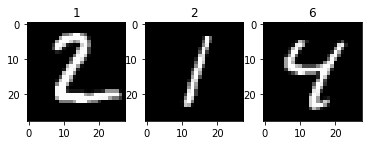

In [60]:
showpre(1,2,6)

## 載入 weight 到另一個 model 應用

In [54]:
model = load_model('my_model_triplet.h5', custom_objects={'triplet_loss': triplet_loss})

In [61]:
weight = model.layers[3].get_weights()

In [62]:
def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


In [63]:
base_network_t = create_base_network(input_shape)

input_d = Input(shape=(input_shape))
input_e = Input(shape=(input_shape))

processed_d = base_network_t(input_d)
processed_e = base_network_t(input_e)

distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_d, processed_e])

model_test = Model(inputs=[input_d, input_e], outputs=distance)
# rms = RMSprop()
# model.compile(loss=contrastive_loss, optimizer=rms)

In [64]:
model_test.set_weights(weight)

In [68]:
def showpre_t(img_num1,img_num2):
    predtest =  model_test.predict([X_test[img_num1:img_num1+1],X_test[img_num2:img_num2+1]])
    print(predtest)
    if(predtest<5):
        print('true')
    else:
        print('false')
    plt.subplot(121),plt.imshow(X_test_image[img_num1], cmap='gray'),plt.title(img_num1)
    plt.subplot(122),plt.imshow(X_test_image[img_num2], cmap='gray'),plt.title(img_num2)
    plt.show()

[[ 2.74455643]]
true


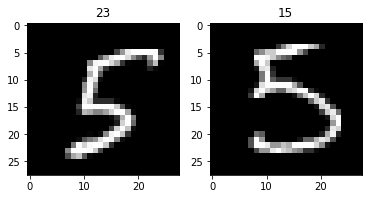

In [70]:
showpre_t(23,15)

## Shape 觀察

In [71]:
tr_pairs[:, 1].shape

(54200, 28, 28, 1)

In [72]:
a = np.reshape(tr_pairs[0],(3,784,-1))

In [73]:
test = triplet(tr_pairs[0])

In [74]:
test = triplet(a)

In [76]:
shape1, shape2 = test.shape

In [77]:
shape2

Dimension(2)

In [39]:
tk = test[:,1]

In [40]:
tk.shape

TensorShape([Dimension(784)])

In [55]:
triplet_loss(1,test).shape[0]

Dimension(1)

In [118]:
qw = []
q = [[0,1],[1,2]]
w = [[0,2],[2,2]]

In [119]:
qw.extend(q)

In [120]:
qw.extend(w)

In [121]:
qw

[[0, 1], [1, 2], [0, 2], [2, 2]]

In [109]:
qw.extend

<function list.extend>

In [110]:
qw

[[[0, 1], [1, 2]], [[0, 2], [2, 2]]]